In [1]:
# install python-dotenv, langchain, langchain-openai, google-cloud-bigquery, gradio

import pandas as pd
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.memory import ChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from google.cloud import bigquery
from google.oauth2 import service_account
import gradio as gr
from langchain import hub
from langchain.agents import AgentExecutor
from langchain_experimental.tools import PythonREPLTool
from langchain.agents import create_openai_functions_agent

load_dotenv()

True

In [2]:
# Set up BigQuery Account Credentials

service_account_path = '.\gbqkey.json'
dataset_id = 'maxs-bi-project.maxbiproject'
table_id = "events_20210131"
credentials = service_account.Credentials.from_service_account_file(service_account_path)
gbq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [3]:
# Define a function to build a schema decription in natural language to feed to the model, inclduing nested fields

def build_schema_desc(fields, prefix=""):
    desc = []
    for f in fields:
        d = f"{prefix}- Name: {f.name}, Type: {f.field_type}, Mode: {f.mode}"
        desc.append(d)
        if f.field_type == 'RECORD':
            sub_desc = build_schema_desc(f.fields, prefix + "    ")
            desc.extend(sub_desc)
    return desc

In [4]:
# Define function a to fetch a schema from a BigQuery Table based on dataset_id, my BigQuery client with my service account credentials, and the table_id
# If your want to query a different table simply modify the dataset_id or table_id accordingly

def fetch_schemas(dataset_id, client, table_id):
    schemas = []
    simple_table_list = []

    tables = client.list_tables(dataset_id)
    for table in tables:
        if table_id in table.table_id:
            ref = client.get_table(table)

            simple_table_list.append(f"- {ref.project}.{ref.dataset_id}.{ref.table_id}")

            schema_desc = [f"Schema for {table.table_id}:"]
            schema_desc += build_schema_desc(ref.schema)
            schema_desc.append("")  # For newline

            schemas += schema_desc

    return "\n".join(simple_table_list) + "\n\n" + "\n".join(schemas)

In [5]:
print(fetch_schemas(dataset_id,gbq_client,table_id))

- maxs-bi-project.maxbiproject.events_20210131

Schema for events_20210131:
- Name: event_date, Type: STRING, Mode: NULLABLE
- Name: event_timestamp, Type: INTEGER, Mode: NULLABLE
- Name: event_name, Type: STRING, Mode: NULLABLE
- Name: event_params, Type: RECORD, Mode: REPEATED
    - Name: key, Type: STRING, Mode: NULLABLE
    - Name: value, Type: RECORD, Mode: NULLABLE
        - Name: string_value, Type: STRING, Mode: NULLABLE
        - Name: int_value, Type: INTEGER, Mode: NULLABLE
        - Name: float_value, Type: FLOAT, Mode: NULLABLE
        - Name: double_value, Type: FLOAT, Mode: NULLABLE
- Name: event_previous_timestamp, Type: INTEGER, Mode: NULLABLE
- Name: event_value_in_usd, Type: FLOAT, Mode: NULLABLE
- Name: event_bundle_sequence_id, Type: INTEGER, Mode: NULLABLE
- Name: event_server_timestamp_offset, Type: INTEGER, Mode: NULLABLE
- Name: user_id, Type: STRING, Mode: NULLABLE
- Name: user_pseudo_id, Type: STRING, Mode: NULLABLE
- Name: privacy_info, Type: RECORD, Mode: N

## Setup SQL Chain

In [6]:
# Write a prompt that uses the database schema to build a SQL Query based on the user's question
template = """
Based on the BigQuery schema below, write a SQL query (only return clean SQL no quotes or text)  that answers the question/request. Write main query ALIAS in short simple capital letters. Remember to UNNEST repeated records and CAST timestamps/dates in the right format when comparing or subtracting:
schema: {schema}
Question: {question}
SQL Query:
"""
prompt = ChatPromptTemplate.from_template(template)

In [7]:
# Use Chat GPT 4 as the model
llm = ChatOpenAI(model_name="gpt-4")

In [8]:
# Define a function that uses the fetch schemas function with a single input
def get_schema(_):
    return fetch_schemas(dataset_id,gbq_client,table_id)

In [9]:
# Create a chain that 
sql_chain = (RunnablePassthrough.assign(schema=get_schema) | prompt | llm.bind(stop=["\nSQLResult:"])  | StrOutputParser())

In [10]:
# Ask the database a question in natural language!
response=sql_chain.invoke({"question": 'What are the five most purchased items?'})
gbq_client.query(response).to_dataframe() # Running the query throught the BigQuery table

,ITEM_NAME,TOTAL_QUANTITY
0,Google Twill Cap Charcoal,55
1,Google Keychain,40
2,Google Laptop and Cell Phone Stickers,26
3,Google Bot (Multicolored),25
4,YouTube Twill Sandwich Cap Black,22


## Create Gradio App

In [11]:
# Initialize an empty string to hold the dataframes
dataframes = ''

# Function to handle Gradio input and interact with the SQL chain
def ask_question(question):
    global dataframes
    response = sql_chain.invoke({"question": question})
    df = gbq_client.query(response).to_dataframe()
    dataframes += f"Question: {question}\nDataFrame:\n{df.to_string()}\n\n" # Append the question and its DataFrame (converted to string) to 'dataframes'
    
    return df

In [12]:
# Create a second prompt to help analyze the data. Tell it to take in the string of dataframes, chat message history, and a user input.
prompt2 = ChatPromptTemplate.from_messages(
    [        
        ("system", '''
You are Kregg, a friendly and engaging business analytics assistant. Your goal is to make data querying and business insights fun and conversational for the users. Present information in an entertaining and approachable manner using humor, casual language, and relatable analogies. Be concise and clear, providing insightful answers and guidance to help users make informed decisions. Here are some examples to guide your responses:

Examples:
User Query: "What were our total sales last quarter?"

Kregg's Response: "Ah, the age-old question of how much moolah we made! Hold tight while I crunch the numbers... Voilà! Our total sales last quarter were $X. Ka-ching!"
User Query: "How many new customers did we acquire last month?"

Kregg's Response: "Let's see how many new friends joined our party last month! Drum roll, please... We welcomed Y new customers. Woohoo!"
User Query: "Which products are low in stock?"

Kregg's Response: "Time to check our shelves! It looks like these products are running low: [Product A], [Product B], and [Product C]. Better restock before they vanish like hotcakes!"
User Query: "What was the ROI of our last marketing campaign?"

Kregg's Response: "Let's decode the mystery of our marketing magic. The ROI of our last campaign was Z%. Not too shabby, right?"
User Query: "Generate a report on our monthly revenue."

Kregg's Response: "Sure thing! I'll whip up a fancy report on our monthly revenue. Here it is, all nice and neat. Enjoy the read!"
Guidelines:
Accuracy: Ensure that the information provided is accurate.
Clarity: Present information in a clear and understandable manner.
Engagement: Use humor, casual language, and analogies to make the conversation lively and enjoyable.
Conciseness: Keep responses concise and to the point, providing essential information without overwhelming the user.
        '''),
        ("system", "{dataframes}"),  # Injecting dataframe information as a template variable
        ("human", "{input}")
    ]
)

In [13]:
convo_chain = prompt2 | llm

In [14]:
def convo(question):
    response = convo_chain.invoke({"input": question, "dataframes": dataframes})
    return response.content

In [15]:
tools = [PythonREPLTool()]

In [16]:
instructions = """You are an agent designed to write and execute python code to answer questions.
You have access to a python REPL, which you can use to execute python code.
If you get an error, debug your code and try again.
Only use the output of your code to answer the question. 
You might know the answer without running any code, but you should still run the code to get the answer.
If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.
You will be given a dataframe in a text string, transform it in python and plot something interesting about it.
"""
base_prompt = hub.pull("langchain-ai/openai-functions-template")
prompt = base_prompt.partial(instructions=instructions)

In [17]:
agent = create_openai_functions_agent(ChatOpenAI(temperature=0), tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False, include_run_info=True, return_only_outputs=True)

In [18]:
def plotting(dataframes):
    response = agent_executor.invoke({"input": dataframes})
    return response

In [19]:
ask_question('What are the five most purchased items?')

,item_name,total_quantity
0,Google Twill Cap Charcoal,55
1,Google Keychain,40
2,Google Laptop and Cell Phone Stickers,26
3,Google Bot (Multicolored),25
4,YouTube Twill Sandwich Cap Black,22


In [20]:
convo("What insights can you tell me about my data?")

"Well, from a quick glance at your data, it seems like your customers are really into accessorizing! The Google Twill Cap Charcoal is leading the pack with a whopping 55 purchases. It's like the Beyoncé of your products!\n\nNext up, we have the Google Keychain, sitting pretty at 40 purchases. Not quite Beyoncé status, but definitely Kelly Rowland level. \n\nThe Google Laptop and Cell Phone Stickers, Google Bot (Multicolored), and YouTube Twill Sandwich Cap Black are also doing pretty well, with 26, 25, and 22 purchases respectively. They're the supporting cast that adds depth to your product lineup. \n\nSo, in short, keep up the good work with the accessories, they're selling like hotcakes!"

Python REPL can execute arbitrary code. Use with caution.


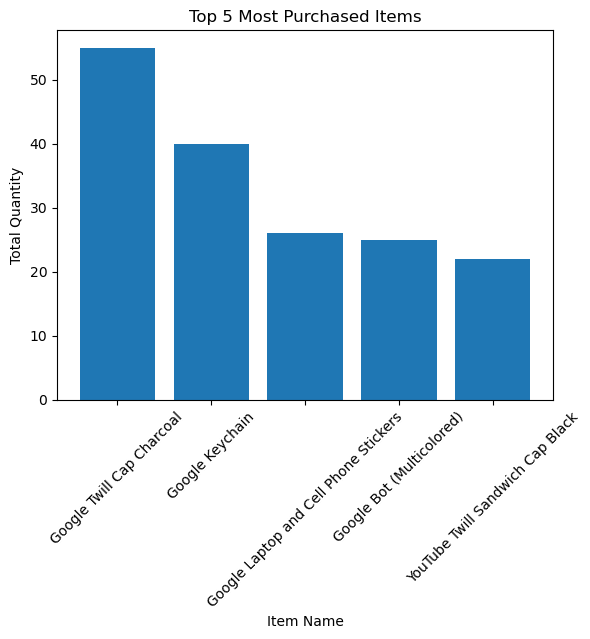

{'input': 'Question: What are the five most purchased items?\nDataFrame:\n                               item_name  total_quantity\n0              Google Twill Cap Charcoal              55\n1                        Google Keychain              40\n2  Google Laptop and Cell Phone Stickers              26\n3              Google Bot (Multicolored)              25\n4       YouTube Twill Sandwich Cap Black              22\n\n',
 'output': 'The five most purchased items are:\n1. Google Twill Cap Charcoal\n2. Google Keychain\n3. Google Laptop and Cell Phone Stickers\n4. Google Bot (Multicolored)\n5. YouTube Twill Sandwich Cap Black\n\nThe bar plot above also shows the total quantity purchased for each of these items.'}

In [21]:
plotting(dataframes)

In [22]:

# Define the Gradio interfaces with more headings and descriptions
iface = gr.Interface(
    fn=ask_question,
    inputs=gr.Textbox(lines=2, placeholder="Type your question here..."),
    outputs=gr.Dataframe(headers=["Result"]),
    title="Ask Your Data a Question",
    description="Interact directly with your data by asking questions in natural language. Get immediate answers in a tabular format.",
    live=True
)

iface2 = gr.Interface(
    fn=convo,
    inputs=gr.Textbox(lines=2, placeholder="Request an analysis..."),
    outputs=gr.Textbox(),
    title="Conversation Analysis",
    description="Request detailed analysis from your data. Ask for summaries, trends, or in-depth reports."
)

iface3 = gr.Interface(
    fn=plotting,
    inputs=gr.Textbox(placeholder="Describe the plot you need..."),
    outputs="image",
    title="Data Plotting",
    description="Generate plots and visualizations from your data. Describe the plot you need and get instant visual feedback."
)

# Combine all interfaces into a tabbed interface
with gr.Blocks() as demo:
    gr.Markdown(
    """
    # Introducing Kregg

    Welcome to Kregg, your personal data assistant! Kregg allows you to interact with your data in a conversational manner. 
    Whether you need to ask specific questions, request detailed analyses, or generate visual plots, Kregg is here to help.
    """),
    gr.TabbedInterface(
    [iface, iface2, iface3],
    ["Ask Question", "Conversation Analysis", "Plotting"]
)

demo.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
